### KDE(Kernel Density Estimation)의 이해

**seaborn의 distplot()을 이용하여 KDE 시각화**  
https://seaborn.pydata.org/tutorial/distributions.html

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877]


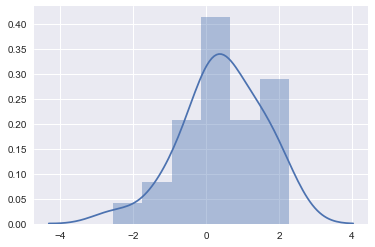

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(color_codes=True)

np.random.seed(0)
x = np.random.normal(0, 1, size=30)
print(x)
sns.distplot(x);

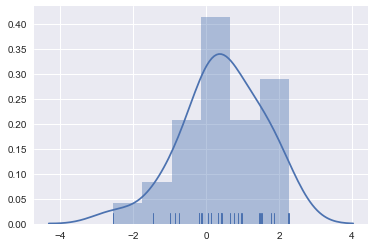

In [3]:
sns.distplot(x, rug=True)

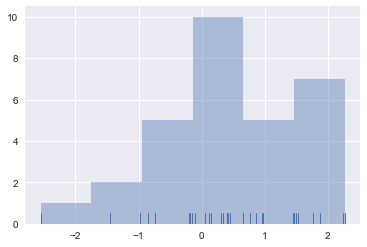

In [4]:
sns.distplot(x, kde=False, rug=True)

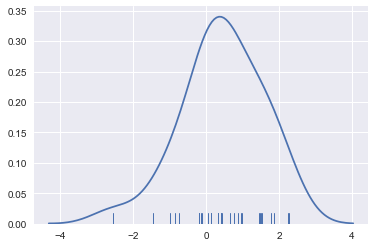

In [5]:
sns.distplot(x, hist=False, rug=True);

**개별 관측데이터에 대해 가우시안 커널 함수를 적용**

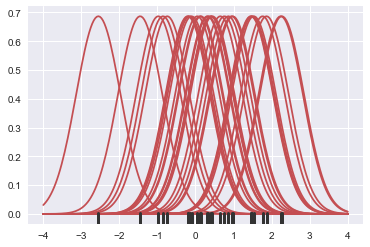

In [7]:
from scipy import stats

#x = np.random.normal(0, 1, size=30)
bandwidth = 1.06 * x.std() * x.size ** (-1 / 5.)
support = np.linspace(-4, 4, 200)

kernels = []
for x_i in x:
    kernel = stats.norm(x_i, bandwidth).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color="r")

sns.rugplot(x, color=".2", linewidth=3);

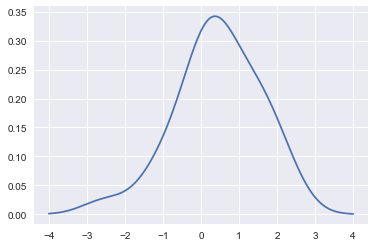

In [8]:
from scipy.integrate import trapz
density = np.sum(kernels, axis=0)
density /= trapz(density, support)
plt.plot(support, density);

**seaborn은 kdeplot()으로 kde곡선을 바로 구할 수 있음**

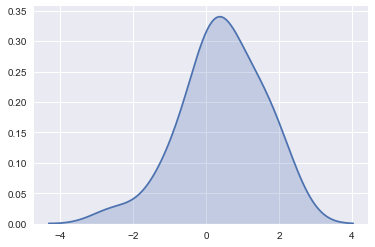

In [9]:
sns.kdeplot(x, shade=True);

**bandwidth에 따른 KDE 변화**

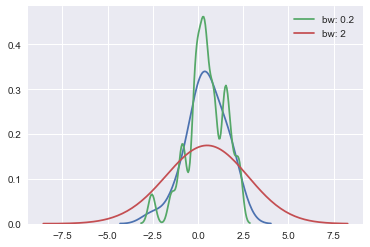

In [10]:
sns.kdeplot(x)
sns.kdeplot(x, bw=.2, label="bw: 0.2")
sns.kdeplot(x, bw=2, label="bw: 2")
plt.legend();

### 사이킷런을 이용한 Mean Shift 

make_blobs()를 이용하여 2개의 feature와 3개의 군집 중심점을 가지는 임의의 데이터 200개를 생성하고 MeanShift를 이용하여 군집화 수행

In [11]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, 
                  cluster_std=0.8, random_state=0)

meanshift= MeanShift(bandwidth=0.9)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5 6 7]


**커널함수의 bandwidth크기를 1로 약간 증가 후에 Mean Shift 군집화 재 수행**

In [12]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


**최적의 bandwidth값을 estimate_bandwidth()로 계산 한 뒤에 다시 군집화 수행**

In [13]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X,quantile=0.25)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.689


In [14]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X, quantile=0.25)

meanshift= MeanShift(best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))    

cluster labels 유형: [0 1 2]


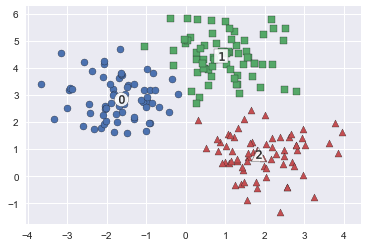

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    # 군집별로 다른 marker로 scatter plot 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', 
                marker=markers[label] )
    
    # 군집별 중심 시각화
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                edgecolor='k', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)
    
plt.show()


In [16]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       1                  67
1       2                  67
2       0                  65
        2                   1
Name: meanshift_label, dtype: int64
